In [1]:
%matplotlib inline
import numpy as np
import cv2
from scipy import signal
import matplotlib.pyplot as plt
from skimage import filters

# Question 1

In [4]:
def vidFrames(cap, num_frames):
    frames = []
    rgb_frames = []
    
    for i in range(num_frames):

        cap.set(1,i);
        ret, image = cap.read()
        
        # successful video read
        if ret:
            
            #Storing both rgb frames and grayscale frames
            rgb_frames.append(image)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            frames.append(image)
            ret_frames  = np.asarray(frames)
            
    return ret_frames, rgb_frames


In [6]:
def vidInfo(cap):
    # check if capture was successful
    if not cap.isOpened(): 
        print("Could not open!")
    else:

        w  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps    = cap.get(cv2.CAP_PROP_FPS)
        
    return w, h, fps

In [8]:
num_frames = 2
cap = cv2.VideoCapture('./data/traffic.mp4')
width, height, fps=vidInfo(cap)
ret_frames,rgb_frames= vidFrames(cap, num_frames)


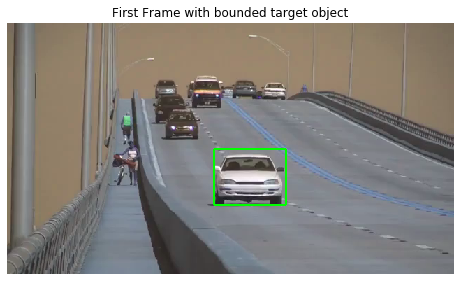

In [10]:
# Boundary coordinates
x1 = 296
y1 = 181
x2 = 399
y2 = 261

# Create boundary 
bounded_frame = cv2.rectangle(rgb_frames[0],(x1, y1),(x2, y2),(0,255,0),2)

# Plot Boundary image
plt.figure(figsize=(8,6))
plt.title('First Frame with bounded target object')
plt.axis('off')
plt.imshow(bounded_frame)

# Q2 - Harris Corner Detection 



(-0.5, 102.5, 79.5, -0.5)

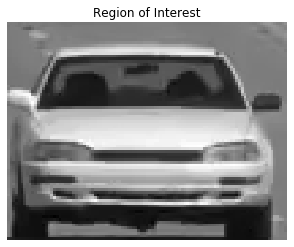

In [21]:
# Using First frame for keypoint detection
frame = ret_frames[0]

# Extracting region of interest -- Tracking white car
roi = frame[y1:y2,x1:x2]

plt.figure()
plt.imshow(roi, cmap='gray')
plt.title("Region of Interest")
plt.axis('off')

In [32]:
def cornerDetection(inp, k=5, window_size=9, alpha=0.04, plots=False):
    
    #First order derivates gradients
    Ix = cv2.Sobel(inp, cv2.CV_64F,1,0,ksize=k)
    Iy = cv2.Sobel(inp, cv2.CV_64F,0,1,ksize=k)
    
    if plots == True:
        plt.figure(figsize=(10,8))
        plt.subplot(2,2,1)
        plt.imshow(Ix, cmap = 'gray')
        plt.title('Gradient Ix')
        plt.axis('off')
        plt.subplot(2,2,2)
        plt.imshow(Iy, cmap = 'gray')
        plt.title('Gradient Iy')
        plt.axis('off')
        plt.show()
    
    #Second order derivates
    Ixx = Ix**2
    Iyy = Iy**2
    Ixy = Ix*Iy
    
    if plots == True:
        plt.figure(figsize=(12,10))
        plt.subplot(3,2,1)
        plt.imshow(Ixx, cmap = 'gray')
        plt.title('Second Order Gradient, Ixx')
        plt.axis('off')
        plt.subplot(3,2,2)
        plt.imshow(Iyy, cmap = 'gray')
        plt.title('Second Order Gradient, Iyy')
        plt.axis('off')
        plt.subplot(3,2,3)
        plt.imshow(Ixy, cmap = 'gray')
        plt.title('Second Order Gradient, Ixy')
        plt.axis('off')
        plt.show()
    
    height = frame.shape[0]
    width = frame.shape[1]
    R = np.zeros((height, width))

    # Offset for window within ROI 
    offset = (window_size-1)/2
   

    for y in range(int(offset), int(height-offset)):
        for x in range(int(offset), int(width-offset)):

            windowIxx = Ixx[int(y-offset):int(y+offset+1), int(x-offset):int(x+offset+1)]
            windowIyy = Iyy[int(y-offset):int(y+offset+1), int(x-offset):int(x+offset+1)]
            windowIxy = Ixy[int(y-offset):int(y+offset+1), int(x-offset):int(x+offset+1)]
            
            # Sum values within window
            Sxx = windowIxx.sum()
            Syy = windowIyy.sum()
            Sxy = windowIxy.sum()
            
            # Covariance Matrix
            M = np.array([(Sxx, Sxy),(Sxy, Syy)])
            
            # Compute Eigenvalues
            eigvals = np.linalg.eigvals(M)

            y1 = eigvals[0]
            y2 = eigvals[1]
            
            #Compute Corner Response, R
            R[y,x] = y1*y2 - alpha*(y1+y2)**2
    
    # Compute best corner coordinates
    #corners = peak_local_max(R, min_distance=10, num_peaks=6)
    
    
    R_th = 0.0
    percentile = 0.995

    R_th = np.quantile(R, percentile)

    height = R.shape[0]
    width = R.shape[1]

    R_binary = np.zeros(R.shape)
    
    # Create a binary R matrix which is thresholded
    for x in range(width):
        for y in range(height):
            if R[y,x] >= R_th:
                R_binary[y,x] = 255

    R_binary = np.array(R_binary, dtype=np.uint8)
    
    #reducing number of points by cv.simpleBlobDetector
    params = cv2.SimpleBlobDetector_Params()
    params.filterByColor = False
    params.filterByInertia = False
    params.filterByConvexity = False
    params.minArea = 60

    det = cv2.SimpleBlobDetector_create(params)
    keypoints = det.detect(R_binary)

    return np.array([[keypoints[i].pt[0], keypoints[i].pt[1]] for i in range(len(keypoints))], dtype=np.float)


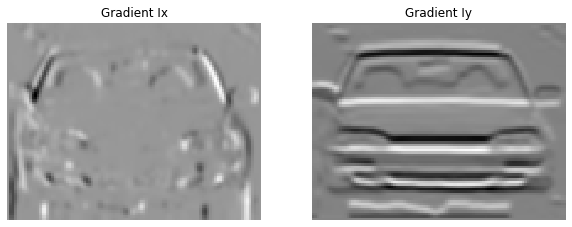

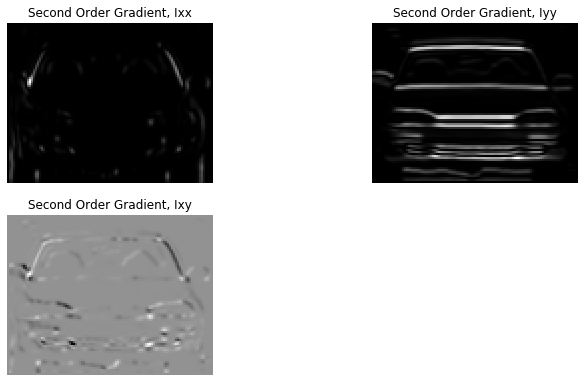

In [33]:
corners = cornerDetection(roi, plots=True)

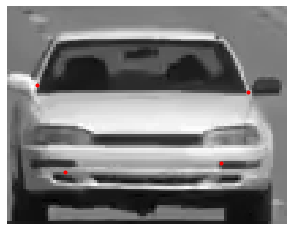

In [34]:
fig, ax = plt.subplots()
#plt.title('Detected Keypoints')
plt.axis('off')
ax.imshow(roi, interpolation='nearest', cmap='gray')
ax.plot(corners[:, 0], corners[:, 1], 'r.')


In [36]:
# shifting keypoints w.r.t original frame
corners[:,0]+=296
corners[:,1]+=181

print(corners )

[[316.88888931 241.31341171]
 [374.24178314 238.03599548]
 [384.         211.87684822]
 [306.49166679 209.49523735]]


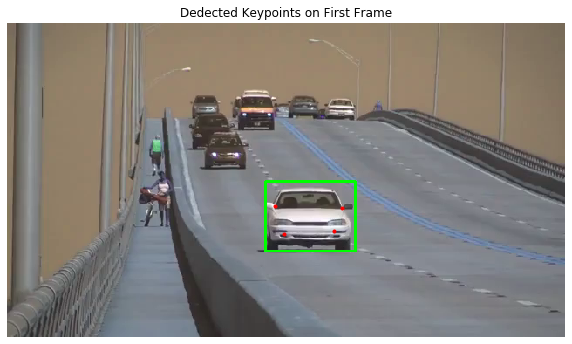

In [37]:
# displaying the found points
ax = plt.figure(figsize=(10,10))
plt.imshow(rgb_frames[0])
plt.plot(corners[:,0], corners[:,1], 'r.')
plt.axis("off")
plt.title('Dedected Keypoints on First Frame')
plt.show()


# Q3 - Horn and Schunck Optical Flow 

In [38]:
def optFlowGradients(im1,im2, plots=False):
    # Initializing Kernels (edge detectors) 
    kx = np.array([[-1,1],[-1,1]])*0.25
    ky = np.array([[-1,-1],[1,1]])*0.25
    kt = np.array([[-1,-1],[-1,-1]])*0.25
    
    # Calculating gradients using Roberts Masks 
    fx = signal.convolve2d(im1, kx, mode='same') + signal.convolve2d(im2, kx, mode='same') 
    fy = signal.convolve2d(im1, ky,  mode='same') + signal.convolve2d(im2, ky,  mode='same')
    ft = signal.convolve2d(im1, kt, mode='same') + signal.convolve2d(im2, -kt, mode='same')
    
    if plots == True:
        plt.figure(figsize=(12,10))
        plt.subplot(3,2,1)
        plt.imshow(fx, cmap = 'gray')
        plt.title('Gradient fx')
        plt.axis('off')
        plt.subplot(3,2,2)
        plt.imshow(fy, cmap = 'gray')
        plt.title('Gradient fy')
        plt.axis('off')
        plt.subplot(3,2,3)
        plt.imshow(ft, cmap = 'gray')
        plt.title('Gradient ft')
        plt.axis('off')
        plt.show()
    
    return fx, fy, ft

In [46]:
def optFlowVectors(fx, fy, ft,kernel, alpha=0.001, iters=15, plots=False):

    # Initialize empty vectors 
    u = np.zeros((height,width))
    v = np.zeros((height,width))

    D = alpha + fx**2 + fy**2
    
    # Iterative method to estimating laplacians
    for i in range(iters):
        
        uav = signal.convolve2d(u, kmean, mode='same') 
        vav = signal.convolve2d(v, kmean, mode='same') 

        P = fx*uav + fy*vav + ft
        u = uav - fx*(P/D)
        v = vav - fy*(P/D)
    
    if plots == True:
        plt.figure(figsize=(12,10))
        plt.subplot(2,2,1)
        plt.imshow(u, cmap = 'gray')
        plt.title('Vector u ')
        plt.axis('off')
        plt.subplot(2,2,2)
        plt.imshow(v, cmap = 'gray')
        plt.title('Vector v')
        plt.axis('off')
        plt.show()
    
    return u, v


In [47]:
def visualizeFlow(U, V, frame):
    # Use Hue, Saturation, Value colour model 
    hsv = np.zeros(frame.shape, dtype=np.uint8)
    mag, ang = cv2.cartToPolar(U,V)

    hsv[..., 1] = 255
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    plt.figure(figsize=(10,10))
    plt.title('Dense Optical Flow between Frame 1 and Frame 2')
    plt.axis('Off')
    plt.imshow(bgr)

    
    return bgr

## Displaying Results of Optical Flow Algorithm 


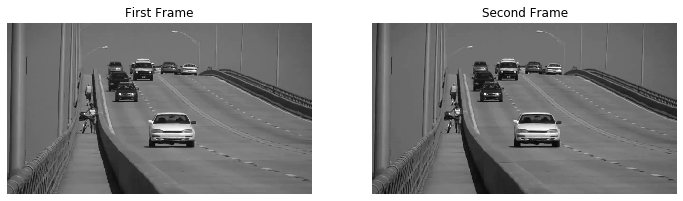

In [48]:
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.imshow(ret_frames[0], cmap = 'gray')
plt.title('First Frame')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(ret_frames[1], cmap = 'gray')
plt.title('Second Frame')
plt.axis('off')
plt.show()

In [49]:
# Initializing mean kernel
kmean = np.array([[1/12, 1/6, 1/12],
                    [1/6, 0, 1/6],
                    [1/12, 1/6, 1/12]], dtype=np.float32)

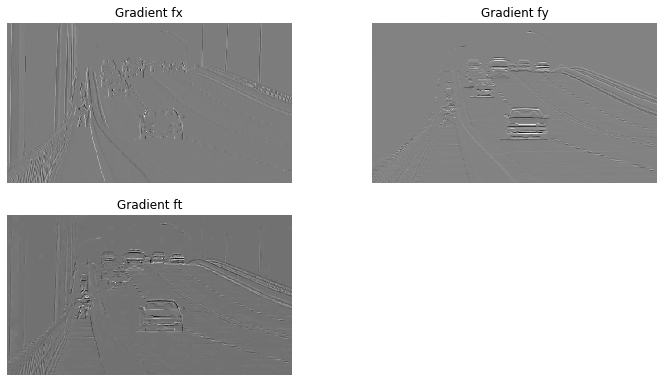

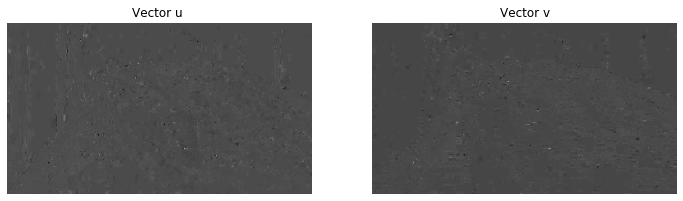

In [50]:
frame1 = ret_frames[0]
frame2 = ret_frames[1]

fx,fy,ft = optFlowGradients(frame1,frame2,plots=True)
u,v = OpticalFlow(fx,fy,ft,kmean,plots=True)


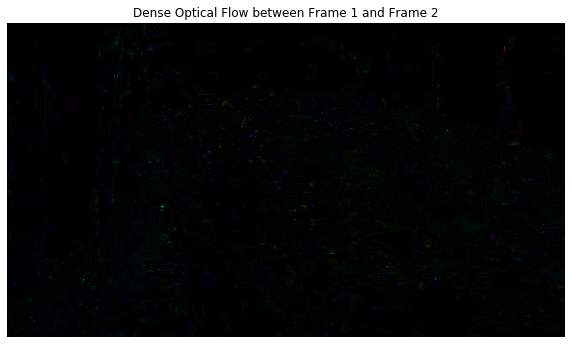

In [51]:
dense_flow = visualizeFlow(u,v,rgb_frames[0])

# Q4-Tracking detected keypoints

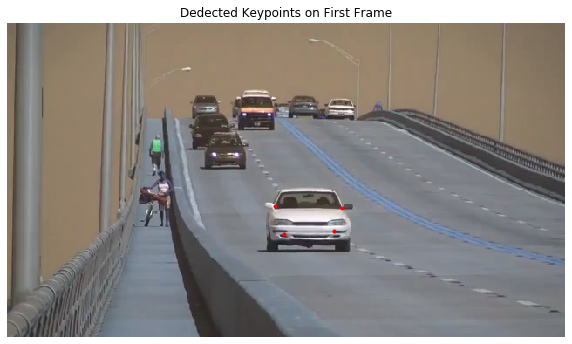

In [121]:
# Capture first 100 frames
num_frames = 100
ret_frames100, rgb_frames100 = getFrames(cap, num_frames)

# Detect corners on first frame within ROI
corners = keyPtsDetector(roi)

# Aligning coordinates
corners[:,0]+=296
corners[:,1]+=181

keypoints_new = np.zeros(corners.shape, dtype='float')
keypoints_all = np.zeros((num_frames, corners.shape[0], corners.shape[1]))

# displaying the found points
ax = plt.figure(figsize=(10,10))
plt.imshow(rgb_frames100[0])
plt.plot(corners[:,0], corners[:,1], 'r.')
plt.axis("off")
plt.title('Dedected Keypoints on First Frame')
plt.show()

In [122]:

def trackPoints(i, keypoints):
    
    # Extract gradients and flow vectors
    fx,fy,ft = optFlowGradients(ret_frames100[i], ret_frames100[i+1])
    u,v = optFlowVectors(fx,fy,ft,kmean)
    
    #Iterate over every keypoint
    for j in range(keypoints_new.shape[0]):
        
        #Display current keypoint value by the u/v-vector at the same index (pixel position)
        keypoints_new[j,0] = keypoints[j,0] - u[int(round(keypoints[j,1])),int(round(keypoints[j,0]))]
        keypoints_new[j,1] = keypoints[j,1] - v[int(round(keypoints[j,1])),int(round(keypoints[j,0]))]
        
        keypoints_all[i,j,:] = keypoints_new[j,:]

    return keypoints_all



In [123]:
for i in range(0,num_frames-1):
    
    _ = trackPoints(i, corners) 


In [145]:
def plotKeyPoints(rgb_frames, keypoints_all, frame_num):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(rgb_frames[frame_num])
    plt.plot(keypoints_all[frame_num,:,0], keypoints_all[frame_num,:,1],'r.')
    plt.title(f'Frame {frame_num}')
    ax.axis('off')

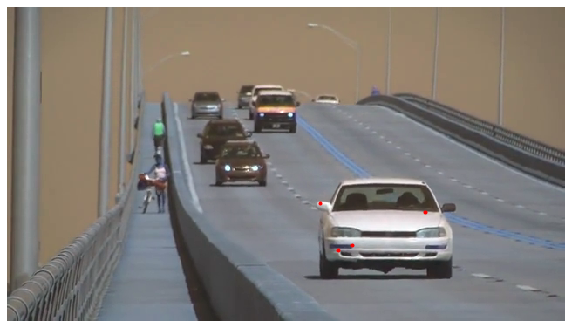

In [144]:
frame_num = 90
plotKeyPoints(rgb_frames100, keypoints_all, frame_num)

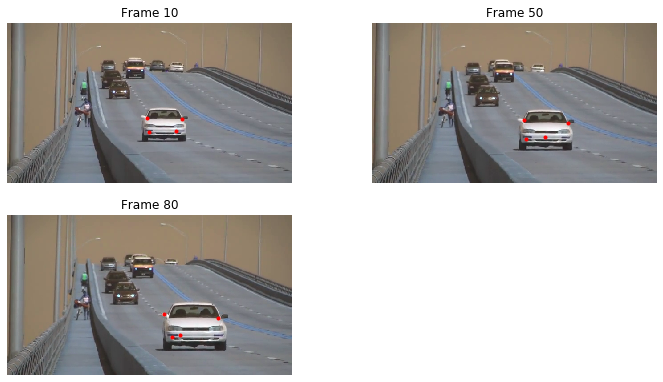

In [135]:
plt.figure(figsize=(12,10))
plt.subplot(3,2,1)
plt.imshow(rgb_frames100[10])
plt.plot(keypoints_all[10,:,0], keypoints_all[10,:,1],'r.')
plt.title('Frame 10')
plt.axis('off')

plt.subplot(3,2,2)
plt.imshow(rgb_frames100[50])
plt.plot(keypoints_all[50,:,0], keypoints_all[50,:,1],'r.')
plt.title('Frame 50')
plt.axis('off')

plt.subplot(3,2,3)
plt.imshow(rgb_frames100[80])
plt.plot(keypoints_all[80,:,0], keypoints_all[80,:,1],'r.')
plt.title('Frame 80')
plt.axis('off')

plt.show()

# Q5 - Plotting Trajectory 

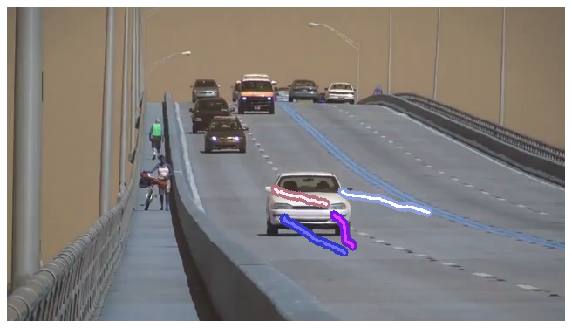

In [152]:
# Initializing trajectory colors and mask 
color = np.random.randint(0,255,(100,3))
mask = np.zeros_like(rgb_frames100[0])

# Iterate over all frames and all keypoints within each frame
for i in range(keypoints_all.shape[0]-2): 
    for j in range(keypoints_all.shape[1]): 
        
        # Starting points and endpoints of each line
        a = int(keypoints_all[i,j,0])
        b = int(keypoints_all[i,j,1])
        c = int(keypoints_all[i+1,j,0])
        d = int(keypoints_all[i+1,j,1])
        
        mask = cv2.line(mask, (a,b),(c,d), color[j].tolist(), 2)
        
        rgb_frames100[0] = cv2.circle(rgb_frames100[0],(a,b),5,color[j].tolist(),-1)

frames_traj = cv2.add(rgb_frames100[0],mask)

ax = plt.figure(figsize=(10,10))
plt.imshow(frames_traj)
plt.axis("off")
#plt.title('Trajectory of the white car during the first 100 frames')
plt.show()